# Содержание

**2. Overview of classification algorithms**

- 2.1 Linear models
    - 2.1.1 Logistic regression
    - 2.1.2 Linear Discriminant Analysis
    - 2.1.3 Support Vector Machine without kernel trick
    
- 2.2 Non-linear models
    - 2.2.1 Adding polynomial features
    - 2.2.2 Quadratic Discriminant Analysis
    - 2.2.3 Support Vector Machine with kernel trick
    - 2.2.4 k-Nearest Neighbors
    - 2.2.5 Decision Trees
    
- 2.3 Ensembles
    - 2.3.1 Bagging
    - 2.3.2 Random Forest
    - 2.3.3 Gradient Boosting

# 2. Overview of classification algorithms

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap

%matplotlib inline

In [2]:
def get_grid(data, border=1., step=.01):
    x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
    y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
    return np.meshgrid(np.arange(x_min, x_max, step),
                       np.arange(y_min, y_max, step))


def make_plot(X, y, predicted=None):

    plt.figure(figsize=(8, 8))
    
    if type(predicted) == np.ndarray:
        plt.pcolormesh(xx, yy, predicted, cmap='Spectral')
        
        custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
        plt.contourf(xx, yy, predicted, alpha=0.3, cmap=custom_cmap)
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(xx, yy, predicted, cmap=custom_cmap2, alpha=0.8)
        
    plt.scatter(X[y==1, 0], X[y==1, 1], c='blue', s=50, alpha=0.6)
    plt.scatter(X[y==0, 0], X[y==0, 1], c='red', s=50, alpha=0.6)
    plt.scatter(X[:, 0], X[:, 1], facecolors='none', edgecolors='black', s=60)
    
    
    
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.grid()
#     plt.show()


def plot_svc_decision_boundary(svm_clf, xmin, xmax):
    w = svm_clf.coef_[0]
    b = svm_clf.intercept_[0]

    # At the decision boundary, w0*x0 + w1*x1 + b = 0
    # => x1 = -w0/w1 * x0 - b/w1
    x0 = np.linspace(xmin, xmax, 200)
    decision_boundary = -w[0]/w[1] * x0 - b/w[1]

    margin = 1/w[1]
    gutter_up = decision_boundary + margin
    gutter_down = decision_boundary - margin

    svs = svm_clf.support_vectors_
#     plt.scatter(svs[:, 0], svs[:, 1], s=180, facecolors='#FFAAAA')
    plt.plot(x0, decision_boundary, "k-", linewidth=2)
    plt.plot(x0, gutter_up, "k--", linewidth=2)
    plt.plot(x0, gutter_down, "k--", linewidth=2)

## Generate some dummy data

(500, 2) (500,)


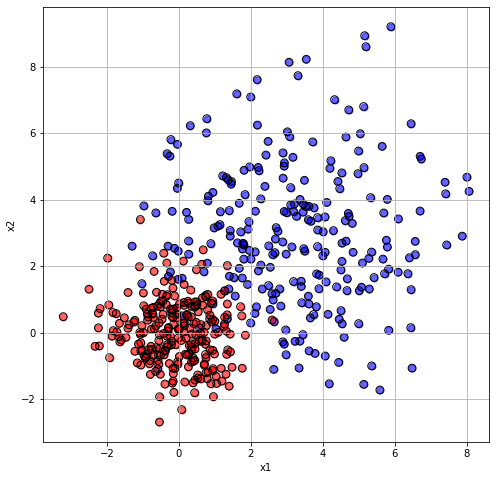

In [3]:
np.random.seed(13)

n = 250
a = np.random.normal(loc=0, scale=1, size=(n, 2))
b = np.random.normal(loc=3, scale=2, size=(n, 2))

X = np.vstack([a, b])
y = np.hstack([np.zeros(n), np.ones(n)])

print(X.shape, y.shape)

xx, yy = get_grid(X)

make_plot(X, y)

# Classification task

For some class labels $y \in \{0, 1\}$ and some features $x$, we want to models the probability

$$Pr(y=1 | x) = p(x)$$

# 2.1 Linear models

## 2.1.1 Logistic regression

Мы уже знакомы с линейной регрессией и методом наименьших квадратов. Рассмотрим задачу бинарной классификации, причем метки целевого класса обозначим "+1" (положительные примеры) и "-1" (отрицательные примеры).
Один из самых простых линейных классификаторов получается на основе регрессии вот таким образом:

$$\Large a(\textbf{x}) = \text{sign}(\textbf{w}^{\text{T}}\textbf x),$$

где
 - $\textbf{x}$ – вектор признаков примера (вместе с единицей);
 - $\textbf{w}$ – веса в линейной модели (вместе со смещением $w_0$);
 - $\text{sign}(\bullet)$ – функция "сигнум", возвращающая знак своего аргумента;
 - $a(\textbf{x})$ – ответ классификатора на примере $\textbf{x}$.
 
### Логистическая регрессия как линейный классификатор

Логистическая регрессия является частным случаем линейного классификатора, но она обладает хорошим "умением" – прогнозировать вероятность $p_+$ отнесения примера $\textbf{x}_\text{i}$ к классу "+":
$$\Large p_+ = \text P\left(y_i = 1 \mid \textbf{x}_\text{i}, \textbf{w}\right) $$

Прогнозирование не просто ответа ("+1" или "-1"), а именно *вероятности* отнесения к классу "+1" во многих задачах является очень важным бизнес-требованием. Например, в задаче кредитного скоринга, где традиционно применяется логистическая регрессия, часто прогнозируют вероятность невозврата кредита ($p_+$). Клиентов, обратившихся за кредитом, сортируют по этой предсказанной вероятности (по убыванию), и получается скоркарта — по сути, рейтинг клиентов от плохих к хорошим. Ниже приведен игрушечный пример такой скоркарты. 
    <img src='./image/toy_scorecard.png' width=60%>

Банк выбирает для себя порог $p_*$ предсказанной вероятности невозврата кредита (на картинке – $0.15$) и начиная с этого значения уже не выдает кредит. Более того, можно умножить предсказнную вероятность на выданную сумму и получить матожидание потерь с клиента, что тоже будет хорошей бизнес-метрикой.

Итак, мы хотим прогнозировать вероятность $p_+ \in [0,1]$, а пока умеем строить линейный прогноз с помощью МНК: $b(\textbf{x}) = \textbf{w}^\text{T} \textbf{x} \in \mathbb{R}$. Каким образом преобразовать полученное значение в вероятность, пределы которой – [0, 1]? Очевидно, для этого нужна некоторая функция $f: \mathbb{R} \rightarrow [0,1].$ В модели логистической регрессии для этого берется конкретная функция: $\sigma(z) = \frac{1}{1 + \exp^{-z}}$.

<a href="https://www.statsmodels.org">statsmodels</a> - это библиотека для статистического моделирования, содержащая всевозможные статистические модели, множество статистических тестов, средств для информативных графиков и др. Распространяется под лицензией New BSD (modified BSD).

Optimization terminated successfully.
         Current function value: 0.162558
         Iterations 9


<ipython-input-2-1d6dfb51e877>:13: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, predicted, cmap='Spectral')


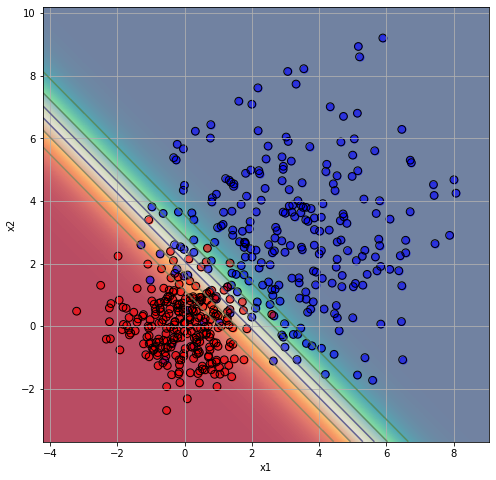

In [4]:
import statsmodels.api as sm

mdl = sm.Logit(y, sm.add_constant(X))
fmdl = mdl.fit()

predicted = fmdl.predict(sm.add_constant(np.c_[xx.ravel(), yy.ravel()])).reshape(xx.shape)
make_plot(X, y, predicted)

In [5]:
fmdl.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                  500
Model:                          Logit   Df Residuals:                      497
Method:                           MLE   Df Model:                            2
Date:                Sun, 21 Mar 2021   Pseudo R-squ.:                  0.7655
Time:                        23:43:56   Log-Likelihood:                -81.279
converged:                       True   LL-Null:                       -346.57
Covariance Type:            nonrobust   LLR p-value:                6.082e-116
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -3.5796      0.390     -9.174      0.000      -4.344      -2.815
x1             1.7719      0.206      8.620      0.000       1.369       2.175
x2             1.6275      0.212      7.687      0.000       1.213       2.042
==============================================================================

Possibly complete quasi-separation: A fraction 0.13 of observations can be
perfectly predicted. This might indicate that there is complete
quasi-separation. In this case some parameters will not be identified.
"""

## 2.1.2 Linear Discriminant Analysis

### Comparison to logistic regression

Logistic regression isn't preferable when:
*   Classes are well-separated
*   *n* is small and distribution of the predictors *X* is approximately normal in each of the classes
*   There are >2 response classes (multiple-class extensions are needed)


### Using Bayes' Theorem for Classification

*Bayes' Theorem*:
$$Pr(Y = k|X = x) = \frac{Pr(Y = k) Pr(X = x | Y = k) }{\sum_{l=1}^K Pr(Y = l) Pr(X = x | Y = l) }$$

Shorter form, where $\pi_k = Pr(Y = k)$, $f_k(x) = Pr(X = x | Y = k)$:

$$Pr(Y = k|X = x) = \frac{\pi_k f_k(x)}{\sum_{l=1}^K \pi_l f_l(x)}$$


$p_k(x) = Pr(Y = k|X = x)$ - *posterior* probability that an observation $X = x$ belongs to the *k*th class.


LDA allows us to compute the posterior probability of the observed sample, $x$, falling into some class $y = 0, 1$, i.e. $p_y(x) := \mathbb{P}[Y=y|X=x]$. This expands with Bayes' Theorem as 

$$p_y(x) = \frac{\pi_y f_y(x)}{\pi_0 f_0(x) + \pi_1 f_1(x)},$$ 

where $f_y = \mathbb{P}[X=x|Y=y]$ is the density of our random vector $X := (X_{sex},...,X_{parch})$. To compute $p_y$, we need to estimate the following distributions on right hand side:
1.   Priors $\pi_0 = Pr(Y = 0),\pi_1 = Pr(Y = 1)$ as the proportions of fatalities and survivors
2.   LDA assumes: $f_y(x)\sim$ multivariate normal density with an identical covariance matrix for each class, $\sum_{y=0} = \sum_{y=1} \in \mathbb{R}^{6\times 6}$.

In reality we could have $X_{\mathrm{sex}, y} \sim \mathrm{Bern}(p_y), X_{\mathrm{age}, y} \sim N(\mu_y, \sigma_y^2), X_{\mathrm{parch},y} \sim \mathrm{Poisson}(\lambda_y)$, etc. FYI: We would probably use **truncated discrete** Gaussian PDF.

<ipython-input-2-1d6dfb51e877>:13: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, predicted, cmap='Spectral')


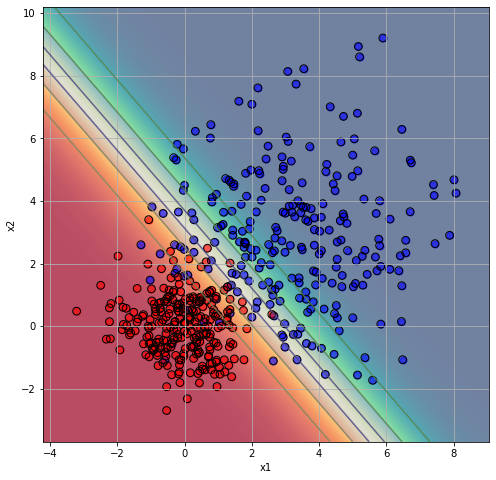

In [6]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda = LinearDiscriminantAnalysis()
lda.fit(X, y)

predicted = lda.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1].reshape(xx.shape)

make_plot(X, y, predicted)

## 2.1.3 Support Vector Machine without kernel trick

## Совсем немного теории

SVM (Support Vector Machine, Машина Опорных Векторов) относится к классу алгоритмов обучения с учителем. Принадлежит семейству линейных алгоритмов классификации с максимальным зазором.

Вспомним задачу бинарной классификации...

### Жесткий зазор (hard-margin)

Если данные являются линейно разделимыми, можно построить такую разделяющую гиперплоскость, которая максимизирует расстояние между двумя параллельными гиперплоскостями (изображение взято из [статьи](https://en.wikipedia.org/wiki/Support_vector_machine)):

<img src="./image/svm_max_sep_hyperplane_with_margin.png" alt="Разделяющая гиперплоскость" style="width: 300px;"/>

Каждая точка данных должна находится на "правильной" стороне от разделяющей гиперплоскости.

Это условие можно записать так:

$$ y_{i} (w^T x_i - b) \geqslant 1, i = 1..n $$

где

$ y $ - метки целевого класса +1 или -1

$ x $ - признаки (каждый признак это вектор)

$ w $ - коэффициенты модели (каждый коэффициент тоже вектор)

Тогда задача построения разделяющей гиперплоскости формулируется так:

$$ \begin{cases} \frac{1}{2} w^T w \to min \\ y_{i} (w^T x_i - b) \geqslant 1, i = 1..n \end{cases} $$

Ближайшие к гиперплоскостям точки называются опорными векторами. Их достаточно для построения модели, все точки не нужны.

### Мягкий зазор (soft-margin)

Если данные не являются линейно разделимыми, часть точек окажется на "неправильной" стороне.

Минимизировать надо функцию потерь. В SVM используется петлевая функция потерь [hinge loss](https://en.wikipedia.org/wiki/Hinge_loss):

$$ \zeta_i = max(0, 1 - y_{i} (w^T x_i - b)) $$

Значение функции потерь равно 0, если точка находится на правильной стороне разделяющей гиперплоскости и пропорционально расстоянию до разделяющей гиперплоскости, если точка находится на неправильной стороне.

На следующем графике приведены zero-one-loss, hinge loss, squared hinge loss:

<img src="./image/svm_loss_functions.png" alt="Функции потерь" style="width: 400px;"/>

Squared hinge loss используется потому, что производная от hinge loss в точке $ y_{i} (w^T x_i - b) = 1 $ не определена.

Задача построения разделяющей гиперплоскости:

$$ \begin{cases} \frac{1}{2} w^T w + C \sum_{i=1}^n \zeta_i \to min \\ y_{i} (w^T x_i - b) \geqslant 1 - \zeta_i , \zeta_i \geqslant 0, i = 1..n \end{cases} $$

где $ C $ определяет соотношение между целями максимизации зазора и уменьшения ошибки.

### Нелинейный случай

Если данные не являются линейно разделимыми, можно попробовать выбрать пространство более высокой размерности в котором они будут линейно разделимыми.

Это означает, что в формулах $ x_i $ надо заменить на функцию $ \phi(x_i) $:

$$ \begin{cases} \frac{1}{2} w^T w + C \sum_{i=1}^n \zeta_i \to min \\ y_{i} (w^T \phi(x_i) - b) \geqslant 1 - \zeta_i , \zeta_i \geqslant 0, i = 1..n \end{cases} $$

Однако, вычислять значение $ \phi(x_i) $ не потребуется.

Запишем вектор коэффициентов $ w $ как линейную комбинацию опорных векторов:

$$ w = \sum_{i=0}^l y_i \alpha_i \phi(x_i) $$

Тогда произведение $ w^T x $ примет вид:

$$ w^T x = \sum_{i=0}^l y_i \alpha_i \phi(x_i) \cdot \phi(x) = \sum_{i=0}^l y_i \alpha_i K(x_i, x) $$

где $K$ - функция ядра.

В библиотеке scikit-learn предлагаются следуюшие функции ядра:

- линейную (linear): $ K(x,x') = \langle x, x' \rangle $
- полиномиальную (polynomial): $ K(x,x') = (\gamma \langle x, x' \rangle + r)^d $
- RBF: $ K(x,x') = e^{-\gamma || x - x' ||^2} $
- сигмоид (sigmoid): $ K(x,x') = tanh(\gamma \langle x, x' \rangle + r) $

Вот такой вот [kernel method](https://en.wikipedia.org/wiki/Kernel_method)

<ipython-input-2-1d6dfb51e877>:13: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, predicted, cmap='Spectral')


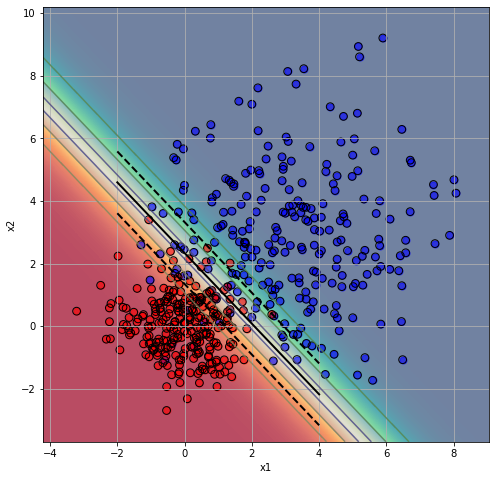

In [7]:
from sklearn.svm import SVC

svc = SVC(
    kernel="linear", 
    probability=True, 
    C=100.)

svc.fit(X, y)

predicted = svc.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1].reshape(xx.shape)

make_plot(X, y, predicted)
plot_svc_decision_boundary(svc, -2, 4)

# 2.2 Non-linear models

## Generate new data

In [8]:
from sklearn.datasets import make_moons
X, y = make_moons(
    n_samples=500, 
    noise=0.20, 
    random_state=42)

xx, yy = get_grid(X)

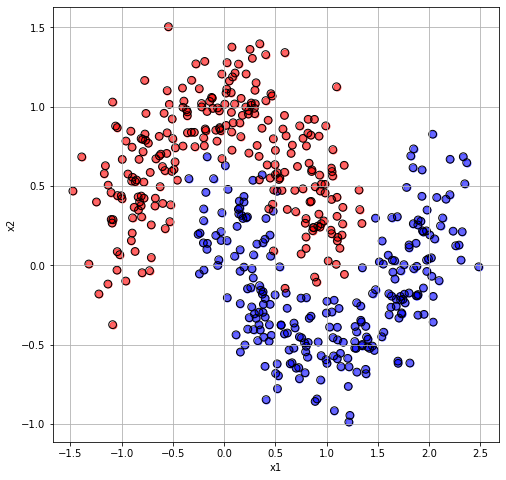

In [9]:
make_plot(X, y)

## Linear models don't work :( 

Optimization terminated successfully.
         Current function value: 0.279706
         Iterations 8


<ipython-input-2-1d6dfb51e877>:13: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, predicted, cmap='Spectral')


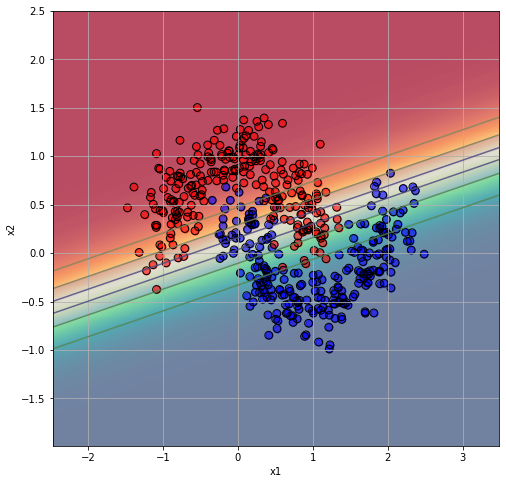

In [10]:
import statsmodels.api as sm

mdl = sm.Logit(y, sm.add_constant(X))
fmdl = mdl.fit()

predicted = fmdl.predict(sm.add_constant(np.c_[xx.ravel(), yy.ravel()])).reshape(xx.shape)

make_plot(X, y, predicted)

## 2.2.1 Adding polynomial features

Historically, the standard way to extend linear regression to settings in which the relationship between the predictors and the response is nonlinear has been to replace the standard linear model $$y_i = \beta_0 + \beta_1x_i + \epsilon_i$$ with a polynomial function $$y_i = \beta_0 + \beta_1x_i + \beta_2x_i^2 + ... + \beta_dx_i^d + \epsilon_i,$$ or $$y_i = \sum_{k=0}^d \beta_kx_i^k + \epsilon_i.$$

Notice that the coefficients $\beta_k$ can be easily estimated
using least squares linear regression because this is just a standard linear model with predictors $x_i^k$.

<ipython-input-2-1d6dfb51e877>:13: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, predicted, cmap='Spectral')


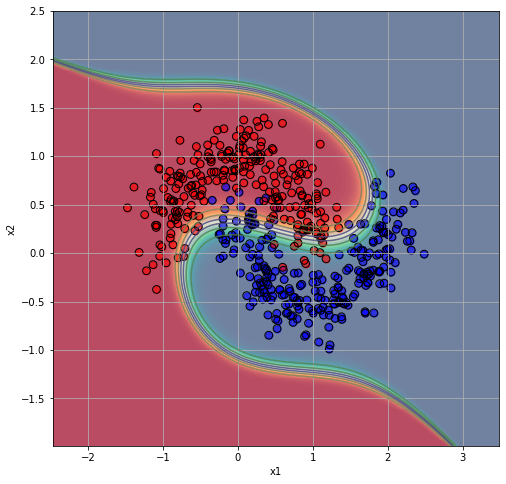

In [11]:
d = 4

from sklearn.preprocessing import PolynomialFeatures

X_poly = PolynomialFeatures(d).fit_transform(X)

X_grid = np.c_[xx.ravel(), yy.ravel()]
X_grid_poly = PolynomialFeatures(d).fit_transform(X_grid)  

lda = LinearDiscriminantAnalysis()
lda.fit(X_poly, y)

predicted = lda.predict_proba(X_grid_poly)[:, 1].reshape(xx.shape)

make_plot(X, y, predicted)

## 2.2.2 Quadratic Discriminant Analysis

QDA assumes multivariate normal for the feature vector of each class, but with differing covariances matrices,  $\sum_{y=0} \neq \sum_{y=1}, \sum_{y} \in \mathbb{R}^{6\times 6}$.

The priors and means are the same as before, but the covariances (not shown) are computed separately for each class $y = 0, 1$.

<ipython-input-2-1d6dfb51e877>:13: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, predicted, cmap='Spectral')


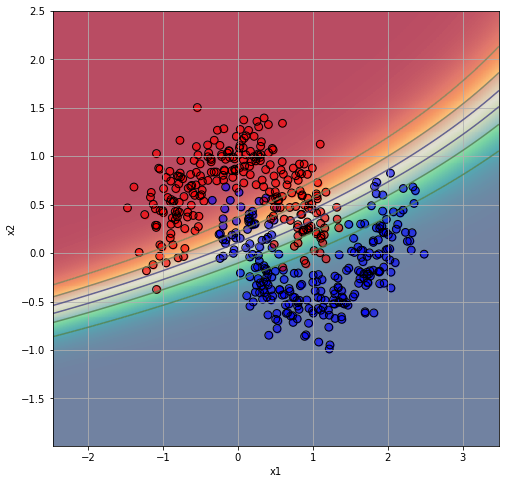

In [12]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

qda = QuadraticDiscriminantAnalysis()
qda.fit(X, y)

predicted = qda.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1].reshape(xx.shape)

make_plot(X, y, predicted)

## 2.2.3 Support Vector Machine with kernel trick

### Polynomial Kernel

- Adding polynomial features is simple to implement and can work great with all sorts
of Machine Learning algorithms (not just SVMs)
- But at a low polynomial degree it cannot deal with very complex datasets, and with a high polynomial degree it creates **a huge number of features**, making the model too slow.

- Fortunately, when using SVMs you can apply an almost miraculous mathematical
technique called *the kernel trick*.
- The kernel trick makes it possible to get the same result as if you added many polynomial features, even with very highdegree polynomials, without actually having to add them. So there is no combinatorial explosion of the number of features since you don’t actually add any features. 
- This trick is implemented by the `SVC` class.

<ipython-input-2-1d6dfb51e877>:13: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, predicted, cmap='Spectral')


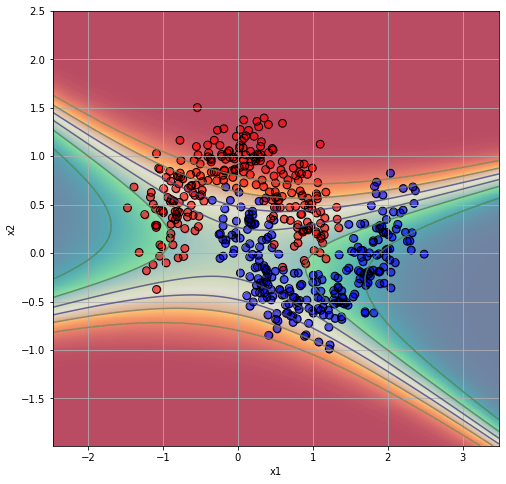

In [13]:
svc = SVC(
    kernel="poly", 
    degree=2, 
    probability=True)

svc.fit(X, y)

predicted = svc.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1].reshape(xx.shape)

make_plot(X, y, predicted)

### Adding Similarity Features

- Another technique to tackle nonlinear problems is to add features computed using a
**similarity function** that measures how much each instance resembles a particular
landmark.

- For example, let’s take the one-dimensional dataset discussed earlier and
add two landmarks to it at $x_1 = –2$ and $x_1 = 1$.
- Next, let’s define the similarity function to be the **Gaussian Radial Basis Function (RBF)** with $γ = 0.3$.

$$\phi_\gamma(\mathbf{x}, \ell)=\exp\left( -\gamma||\mathbf{x}-\ell||^2\right)$$

It is a bell-shaped function varying from 0 (very far away from the landmark) to 1 (at the landmark).

<ipython-input-2-1d6dfb51e877>:13: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, predicted, cmap='Spectral')


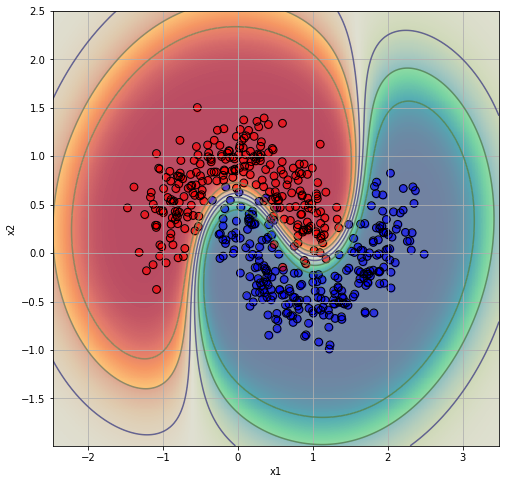

In [14]:
from sklearn.svm import SVC

svc = SVC(
    kernel="rbf", 
    probability=True)

svc.fit(X, y)

predicted = svc.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1].reshape(xx.shape)
make_plot(X, y, predicted)

## 2.2.4 k-Nearest Neighbors

Метрический алгоритм классификации:
$$
    a(x, X^l) = \arg \max_{y \in Y} \sum_{i = 1}^{l}[y_i = y] ~ w(i, x)
$$

где $w(i, x)$ - вес (степень важности) i-ого соседа объекта $x$. Обычно $w(i, x)$ обратно пропорционален расстоянию от i-ого соседа до объекта x.

![](https://upload.wikimedia.org/wikipedia/commons/e/e7/KnnClassification.svg)

<ipython-input-2-1d6dfb51e877>:13: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, predicted, cmap='Spectral')


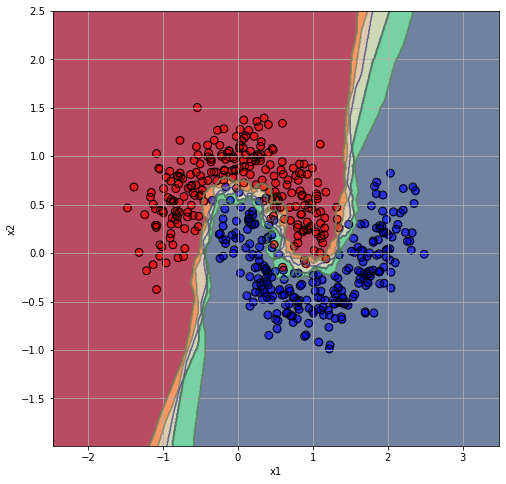

In [15]:
from sklearn.neighbors import KNeighborsClassifier as KNN

knn = KNN(n_neighbors=5, p=2)
knn.fit(X, y)

predicted = knn.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1].reshape(xx.shape)

make_plot(X, y, predicted)

## 2.2.5 Decision Trees

Начнем обзор методов классификации и регрессии с одного из самых популярных – с дерева решений. Деревья решений используются в повседневной жизни в самых разных областях человеческой деятельности, порой и очень далеких от машинного обучения. Деревом решений можно назвать наглядную инструкцию, что делать в какой ситуации.

Зачастую дерево решений служит обобщением опыта экспертов, средством передачи знаний будущим сотрудникам или моделью бизнес-процесса компании. Например, до внедрения масштабируемых алгоритмов машинного обучения в банковской сфере задача кредитного скоринга решалась экспертами. Решение о выдаче кредита заемщику принималось на основе некоторых интуитивно (или по опыту) выведенных правил, которые можно представить в виде дерева решений.

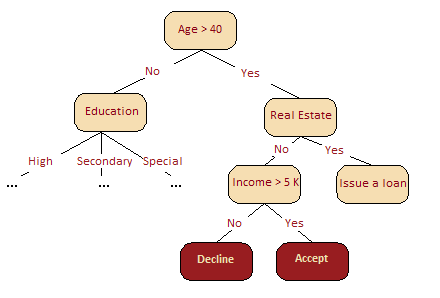

В этом случае можно сказать, что решается задача бинарной классификации (целевой класс имеет два значения: "Выдать кредит" и "Отказать") по признакам "Возраст", "Наличие дома", "Доход" и "Образование".

Дерево решений как алгоритм машинного обучения – по сути то же самое: объединение логических правил вида "Значение признака $a$ меньше $x$ И Значение признака $b$ меньше $y$ ... => Класс 1" в структуру данных "Дерево". Огромное преимущество деревьев решений в том, что они легко интерпретируемы, понятны человеку. Например, по схеме на рисунке выше можно объяснить заемщику, почему ему было отказано в кредите. Скажем, потому, что у него нет дома и доход меньше 5000. Как мы увидим дальше, многие другие, хоть и более точные, модели не обладают этим свойством и могут рассматриваться скорее как "черный ящик", в который загрузили данные и получили ответ. В связи с этой "понятностью" деревьев решений и их сходством с моделью принятия решений человеком (можно легко объяснять боссу свою модель), деревья решений получили огромную популярность, а один из представителей этой группы методов классификации, С4.5, рассматривается первым в списке 10 лучших алгоритмов интеллектуального анализа данных ("Top 10 algorithms in data mining", Knowledge and Information Systems, 2008. [PDF](http://www.cs.uvm.edu/~icdm/algorithms/10Algorithms-08.pdf)).

## Как строится дерево решений

В примере с кредитным скорингом мы видели, что решение о выдаче кредита принималось на основе возраста, наличия недвижимости, дохода и других. Но какой признак выбрать первым? Для этого рассмотрим пример попроще, где все признаки бинарные.

Здесь можно вспомнить игру "20 вопросов", которая часто упоминается во введении в деревья решений. Наверняка каждый в нее играл. Один человек загадывает знаменитость, а второй пытается отгадать, задавая только вопросы, на которые можно ответить "Да" или "Нет" (опустим варианты "не знаю" и "не могу сказать"). Какой вопрос отгадывающий задаст первым делом? Конечно, такой, который сильнее всего уменьшит количество оставшихся вариантов. К примеру, вопрос "Это Анджелина Джоли?" в случае отрицательного ответа оставит более 6 миллиардов вариантов для дальнейшего перебора (конечно, поменьше, не каждый человек – знаменитость, но все равно немало), а вот вопрос "Это женщина?" отсечет уже около половины знаменитостей. То есть, признак "пол" намного лучше разделяет выборку людей, чем признак "это Анджелина Джоли", "национальность-испанец" или "любит футбол". Это интуитивно соответствует понятию прироста информации, основанного на энтропии.

#### Энтропия
Энтропия Шеннона определяется для системы с $N$ возможными состояниями следующим образом:

$$\Large S = -\sum_{i=1}^{N}p_ilog_2p_i,$$

где  $p_i$ – вероятности нахождения системы в $i$-ом состоянии. Это очень важное понятие, используемое в физике, теории информации и других областях. Опуская предпосылки введения (комбинаторные и теоретико-информационные) этого понятия, отметим, что, интуитивно, энтропия соответствует степени хаоса в системе. Чем выше энтропия, тем менее упорядочена система и наоборот. Это поможет там формализовать "эффективное разделение выборки", про которое мы говорили в контексте игры "20 вопросов".

<h4>Пример</h4>
Для иллюстрации того, как энтропия поможет определить хорошие признаки для построения дерева, приведем тот же игрушечный пример, что в статье <a href="https://habrahabr.ru/post/171759/">"Энтропия и деревья принятия решений"</a>. Будем предсказывать цвет шарика по его координате. Конечно, ничего общего с жизнью это не имеет, но позволяет показать, как энтропия используется для построения дерева решений.
<img src="https://habrastorage.org/files/c96/80a/a4b/c9680aa4babc40f4bbc8b3595e203979.png"/><br>

Здесь 9 синих шариков и 11 желтых. Если мы наудачу вытащили шарик, то он с вероятностью   $p_1=\frac{9}{20}$ будет синим и с вероятностью  $p_2=\frac{11}{20}$ – желтым. Значит, энтропия состояния  $S_0 = -\frac{9}{20}log_2{\frac{9}{20}}-\frac{11}{20}log_2{\frac{11}{20}} \approx 1$. Само это значение пока ни о чем нам не говорит. Теперь посмотрим, как изменится энтропия, если разбить шарики на две группы – с координатой меньше либо равной 12 и больше 12.
<img src="https://habrastorage.org/files/186/444/a8b/186444a8bd0e451c8324ca8529f8d4f4.png"/><br>

В левой группе оказалось 13 шаров, из которых 8 синих и 5 желтых. Энтропия этой группы равна $S_1 = -\frac{5}{13}log_2{\frac{5}{13}}-\frac{8}{13}log_2{\frac{8}{13}} \approx 0.96$. В правой группе оказалось 7 шаров, из которых 1 синий и 6 желтых. Энтропия правой группы равна $S_2 = -\frac{1}{7}log_2{\frac{1}{7}}-\frac{6}{7}log_2{\frac{6}{7}} \approx 0.6$. Как видим, энтропия уменьшилась в обеих группах по сравнению с начальным состоянием, хоть в левой и не сильно. Поскольку энтропия – по сути степень хаоса (или неопределенности) в системе, уменьшение энтропии называют приростом информации. Формально прирост информации (information gain, IG) при разбиении выборки по признаку $Q$ (в нашем примере это признак "$x \leq 12$") определяется как 
$$\Large IG(Q) = S_O - \sum_{i=1}^{q}\frac{|N_i|}{N}S_i,$$
где $q$ – число групп после разбиения, $N_i$ – число элементов выборки, у которых признак $Q$ имеет $i$-ое значение. В нашем случае после разделения получилось две группы ($q = 2$) – одна из 13 элементов ($N_1 = 13$), вторая – из 7 ($N_2 = 7$). Прирост информации получился 
$$\Large IG("x \leq 12") = S_0 - \frac{13}{20}S_1 - \frac{7}{20}S_2 \approx 0.16.$$
Получается, разделив шарики на две группы по признаку "координата меньше либо равна 12", мы уже получили более упорядоченную систему, чем в начале. Продолжим деление шариков на группы до тех пор, пока в каждой группе шарики не будут одного цвета.  
<img src="https://habrastorage.org/files/dae/a88/2b0/daea882b0a8e4ef4b23325c88f0353a1.png"/><br>
Для правой группы потребовалось всего одно дополнительное разбиение по признаку "координата меньше либо равна 18", для левой – еще три. Очевидно, энтропия группы с шариками одного цвета равна 0 ($log_2{1} = 0$), что соответствует представлению, что группа шариков одного цвета – упорядоченная. 
В итоге мы построили дерево решений, предсказывающее цвет шарика по его координате. Отметим, что такое дерево решений может плохо работать для новых объектов (определения цвета новых шариков), поскольку оно идеально подстроилось под обучающую выборку (изначальные 20 шариков). Для классификации новых шариков лучше подойдет дерево с меньшим числом "вопросов", или разделений, пусть даже оно и не идеально разбивает по цветам обучающую выборку. Эту проблему, переобучение, мы еще рассмотрим далее. 

#### Алгоритм построения дерева

Можно убедиться в том, что построенное в предыдущем примере дерево является в некотором смысле оптимальным – потребовалось только 5 "вопросов" (условий на признак $x$), чтобы "подогнать" дерево решений под обучающую выборку, то есть чтобы дерево правильно классифицировало любой обучающий объект. При других условиях разделения выборки дерево получится глубже. 

В основе популярных алгоритмов построения дерева решений, таких как ID3 и C4.5, лежит принцип жадной максимизации прироста информации – на каждом шаге выбирается тот признак, при разделении по которому прирост информации оказывается наибольшим. Дальше процедура повторяется рекурсивно, пока энтропия не окажется равной нулю или какой-то малой величине (если дерево не подгоняется идеально под обучающую выборку во избежание переобучения).
В разных алгоритмах применяются разные эвристики для "ранней остановки" или "отсечения", чтобы избежать построения переобученного дерева. 

```python
def build(L):
    create node t
    if the stopping criterion is True:
        assign a predictive model to t
    else:
        Find the best binary split L = L_left + L_right
        t.left = build(L_left)
        t.right = build(L_right)
    return t     
```

#### Другие критерии качества разбиения в задаче классификации

Мы разобрались, в том, как понятие энтропии позволяет формализовать представление о качестве разбиения в дереве. Но это всего-лишь эвристика, существуют и другие:

 - Неопределенность Джини (Gini impurity):  $G = 1 - \sum\limits_k (p_k)^2$. Максимизацию этого критерия можно интерпретировать как максимизацию числа пар объектов одного класса, оказавшихся в одном поддереве. Подробнее об этом (как и обо многом другом) можно узнать из [репозитория](https://github.com/esokolov/ml-course-msu) Евгения Соколова. Не путать с индексом Джини! Подробнее об этой путанице – в [блогпосте](https://alexanderdyakonov.wordpress.com/2015/12/15/%D0%B7%D0%BD%D0%B0%D0%BA%D0%BE%D0%BC%D1%8C%D1%82%D0%B5%D1%81%D1%8C-%D0%B4%D0%B6%D0%B8%D0%BD%D0%B8/) Александра Дьяконова
 - Ошибка классификации (misclassification error):  $E = 1 - \max\limits_k p_k$
 
 
На практике ошибка классификации почти не используется, а неопределенность Джини и прирост информации работают почти одинаково.

В случае задачи бинарной классификации ($p_+$ – вероятность объекта иметь метку +) энтропия и неопределенность Джини примут следующий вид:<br><br>
$$ S = -p_+ \log_2{p_+} -p_- \log_2{p_-} = -p_+ \log_2{p_+} -(1 - p_{+}) \log_2{(1 - p_{+})};$$
$$ G = 1 - p_+^2 - p_-^2 = 1 - p_+^2 - (1 - p_+)^2 = 2p_+(1-p_+).$$

Когда мы построим графики этух двух функций от аргумента $p_+$, то увидим, что график энтропии очень близок к графику удвоенной неопределенности Джини, и поэтому на практике эти два критерия "работают" почти одинаково.

### Основные параметры дерева

В принципе дерево решений можно построить до такой глубины, чтоб в каждом листе был ровно один объект. Но на практике это не делается из-за того, что такое дерево будет *переобученным* – оно слишком настроится на обучающую выборку и будет плохо работать на прогноз на новых данных. Где-то внизу дерева, на большой глубине будут появляться разбиения по менее важным признакам (например, приехал ли клиент из Саратова или Костромы). Если утрировать, может оказаться так, что из всех 4 клиентов, пришедших в банк за кредитом в зеленых штанах, никто не вернул кредит. Но мы не хотим, чтобы наша модель классификации порождала такие специфичные правила. 

Основные способы борьбы с переобучением в случае деревьев решений:
 - искусственное ограничение глубины или минимального числа объектов в листе: построение дерева просто в какой-то момент прекращается;
 - стрижка дерева (*pruning*). При таком подходе дерево сначала строится до максимальной глубины, потом постепенно, снизу вверх, некоторые вершины дерева убираются за счет сравнения по качеству дерева с данным разбиением и без него (сравнение проводится с помощью *кросс-валидации*, о которой чуть ниже). Подробнее можно почитать в  материалах [репозитория](https://github.com/esokolov/ml-course-msu) Евгения Соколова.

### Класс DecisionTreeClassifier в Scikit-learn
Основные параметры класса [sklearn.tree.DecisionTreeClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html):

- `max_depth` – максимальная глубина дерева
- `max_features` - максимальное число признаков, по которым ищется лучшее разбиение в дереве (это нужно потому, что при большом количестве признаков будет "дорого" искать лучшее (по критерию типа прироста информации) разбиение среди *всех* признаков)
- `min_samples_leaf` – минимальное число объектов в листе. У этого параметра есть понятная интерпретация: скажем, если он равен 5, то дерево будет порождать только те классифицирующие правила, которые верны как мимимум для 5 объектов

Параметры дерева надо настраивать в зависимости от входных данных, и делается это обычно с помощью *кросс-валидации*,  про нее чуть ниже.


<ipython-input-2-1d6dfb51e877>:13: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, predicted, cmap='Spectral')


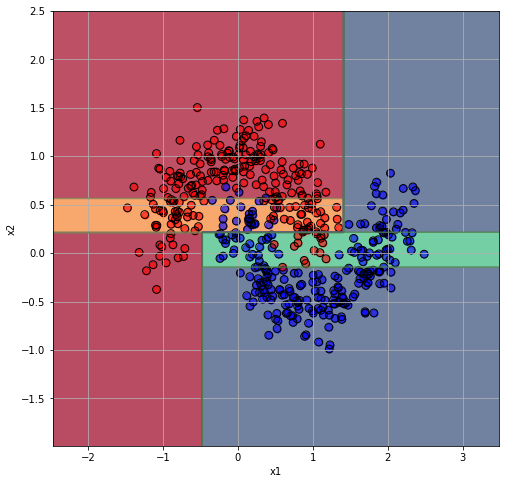

In [16]:
from sklearn.tree import DecisionTreeClassifier

tree_clf = DecisionTreeClassifier(max_depth=3, random_state=42)
tree_clf.fit(X, y)

predicted = tree_clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1].reshape(xx.shape)

make_plot(X, y, predicted)

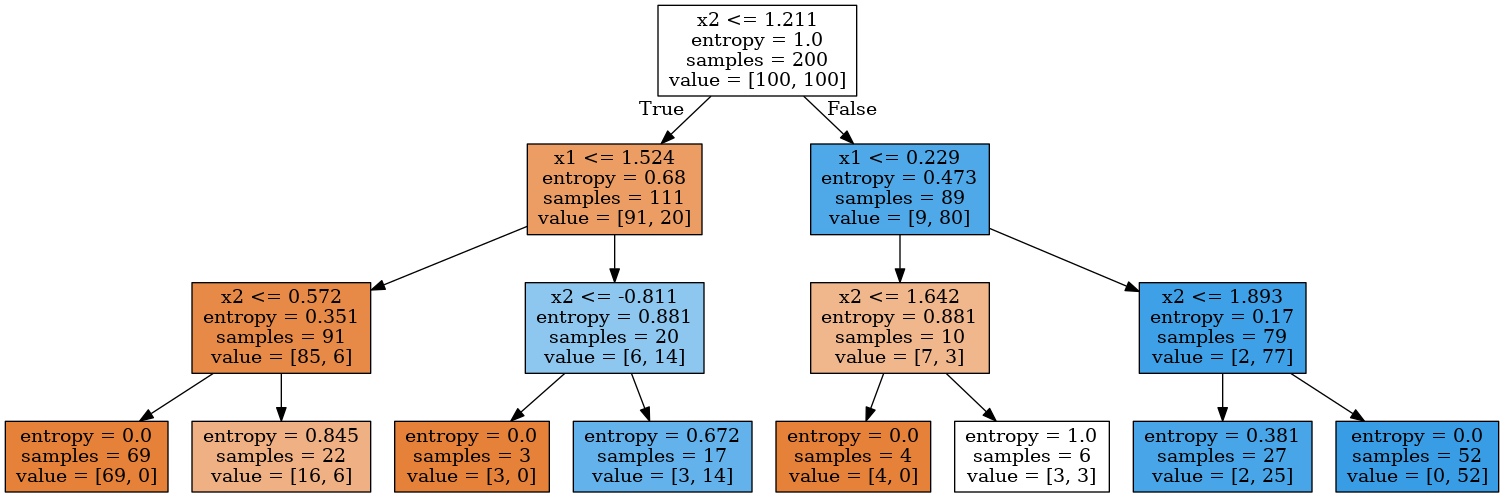

# 2.3 Ensembles

## 2.3.1 Bagging

Bagging (от Bootstrap aggregation) — это один из первых и самых простых видов ансамблей. Он был придуман [Ле́о Бре́йманом](https://ru.wikipedia.org/wiki/Брейман,_Лео) в 1994 году. Бэггинг основан на статистическом методе бутстрэппинга, который позволяет оценивать многие статистики сложных моделей.

Метод бутстрэпа заключается в следующем. Пусть имеется выборка $\large X$ размера $\large N$. Равномерно возьмем из выборки $\large N$ объектов с возвращением. Это означает, что мы будем $\large N$ раз выбирать произвольный объект выборки (считаем, что каждый объект «достается» с одинаковой вероятностью $\large \frac{1}{N}$), причем каждый раз мы выбираем из всех исходных $\large N$ объектов. Можно представить себе мешок, из которого достают шарики: выбранный на каком-то шаге шарик возвращается обратно в мешок, и следующий выбор опять делается равновероятно из того же числа шариков. Отметим, что из-за возвращения среди них окажутся повторы. Обозначим новую выборку через $\large X_1$. Повторяя процедуру $\large M$ раз, сгенерируем $\large M$ подвыборок $\large X_1, \dots, X_M$. Теперь мы имеем достаточно большое число выборок и можем оценивать различные статистики исходного распределения.

Теперь вы имеете представление о бустрэпе, и мы можем перейти непосредственно к бэггингу. Пусть имеется обучающая выборка $\large X$. С помощью бутстрэпа сгенерируем из неё выборки $\large X_1, \dots, X_M$. Теперь на каждой выборке обучим свой классификатор $\large a_i(x)$. Итоговый классификатор будет усреднять ответы всех этих алгоритмов (в случае классификации это соответствует голосованию): $\large a(x) = \frac{1}{M}\sum_{i = 1}^M a_i(x)$. Эту схему можно представить картинкой ниже.

<img src="./image/bagging.png" alt="image"/>

Рассмотрим задачу регрессии с базовыми алгоритмами $\large b_1(x), \dots , b_n(x)$. Предположим, что существует истинная функция ответа для всех объектов $\large y(x)$, а также задано распределение на объектах $\large p(x)$. В этом случае мы можем записать ошибку каждой функции регрессии $$ \large \varepsilon_i(x) = b_i(x) − y(x),  i = 1, \dots, n$$
и записать матожидание среднеквадратичной ошибки $$ \large E_x(b_i(x) − y(x))^{2} = E_x \varepsilon_i (x). $$

Средняя ошибка построенных функций регрессии имеет вид $$ \large E_1 = \frac{1}{n}E_x \sum_{i=1}^n \varepsilon_i^{2}(x) $$

Предположим, что ошибки несмещены и некоррелированы: 

$$ \large \begin{array}{rcl} E_x\varepsilon_i(x) &=& 0, \\
E_x\varepsilon_i(x)\varepsilon_j(x) &=& 0, i \neq j. \end{array}$$

Построим теперь новую функцию регрессии, которая будет усреднять ответы построенных нами функций:
$$ \large a(x) = \frac{1}{n}\sum_{i=1}^{n}b_i(x) $$

Найдем ее среднеквадратичную ошибку:

$$ \large \begin{array}{rcl}E_n &=& E_x\Big(\frac{1}{n}\sum_{i=1}^{n}b_i(x)-y(x)\Big)^2 \\
&=& E_x\Big(\frac{1}{n}\sum_{i=1}^{n}\varepsilon_i\Big)^2 \\
&=& \frac{1}{n^2}E_x\Big(\sum_{i=1}^{n}\varepsilon_i^2(x) + \sum_{i \neq j}\varepsilon_i(x)\varepsilon_j(x)\Big) \\
&=& \frac{1}{n}E_1\end{array}$$

Таким образом, усреднение ответов позволило уменьшить средний квадрат ошибки в n раз!

<ipython-input-2-1d6dfb51e877>:13: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, predicted, cmap='Spectral')


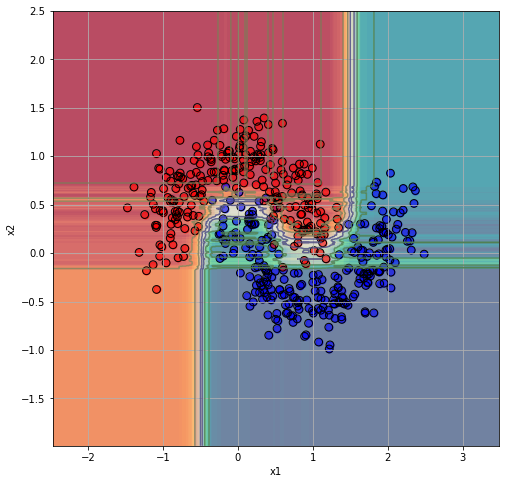

In [17]:
from sklearn.ensemble import BaggingClassifier

bag_clf = BaggingClassifier(
            DecisionTreeClassifier(random_state=42),
            n_estimators=100,
            max_samples=100,
            bootstrap=True,
            random_state=42)

bag_clf.fit(X, y)

predicted = bag_clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1].reshape(xx.shape)

make_plot(X, y, predicted)

## 2.3.2 Random Forest

Лео Брейман нашел применение бутстрэпу не только в статистике, но и в машинном обучении. Он вместе с Адель Катлер усовершенстовал алгоритм случайного леса, который был предложенный [Хо](http://ect.bell-labs.com/who/tkh/publications/papers/odt.pdf), добавив к первоначальному варианту построение некоррелируемых деревьев на основе CART, в сочетании с методом случайных подпространств и бэггинга. 

Решающие деревья являются хорошим семейством базовых классификаторов для бэггинга, поскольку они достаточно сложны и могут достигать нулевой ошибки на любой выборке. Метод случайных подпространств позволяет снизить коррелированность между деревьями и избежать переобучения. Базовые алгоритмы обучаются на различных подмножествах признакового описания, которые также выделяются случайным образом.
Ансамбль моделей, использующих метод случайного подпространства, можно построить, используя следующий алгоритм:
1. Пусть количество объектов для тренировки равно $\large N$, а количество признаков $\large D$.
2. Выберите $\large L$ как число отдельных моделей в ансамбле.
3. Для каждой отдельной модели $\large l$ выберите $\large dl (dl < D) $ как число признаков для $\large l$ . Обычно для всех моделей используется только одно значение $\large dl$.
4. Для каждой отдельной модели $\large l$ создайте обучающую выборку, выбрав $\large dl$-признаков из $\large D$ с заменой и обучите модель.

Теперь, чтобы применить модель ансамбля к новому объекту, объедините результаты отдельных $\large L$ моделей мажоритарным голосованием или путем комбинирования апостериорных вероятностей.


### Алгоритм

Алгоритм построения случайного леса, состоящего из $\large N$ деревьев, выглядит следующим образом:
* Для каждого $\large n = 1, \dots, N$:
     * Сгенерировать выборку $\large X_n$ с помощью bootstrap.
     * Построить решающее дерево $\large b_n$ по выборке $\large X_n$:
         — по заданному критерию мы выбираем лучший признак, делаем разбиение в дереве по нему и так до исчерпания выборки
         — дерево строится, пока в каждом листе не более $\large n_\text{min}$ объектов или пока не достигнем определенной высоты дерева
         — при каждом разбиении сначала выбирается $\large m$ случайных признаков из $\large n$ исходных, 
         и оптимальное разделение выборки ищется только среди них.
         
Итоговый классификатор $\large a(x) = \frac{1}{N}\sum_{i = 1}^N b_i(x)$, простыми словами — для задачи кассификации мы выбираем решение голосованием по большинству, а в задаче регрессии — средним.

Рекомендуется в задачах классификации брать $\large m = \sqrt{n}$, а в задачах регрессии — $\large m = \frac{n}{3}$, где $\large n$ — число признаков. Также рекомендуется в задачах классификации строить каждое дерево до тех пор, пока в каждом листе не окажется по одному объекту, а в задачах регрессии — пока в каждом листе не окажется по пять объектов.

Таким образом, случайный лес — это бэггинг над решающими деревьями, при обучении которых для каждого разбиения признаки выбираются из некоторого случайного подмножества признаков.

### Параметры

Метод случайного леса реализован в библиотеке машинного обучения [scikit-learn](http://scikit-learn.org/stable/) двумя классами RandomForestClassifier и RandomForestRegressor.

Полный список параметров случайного леса для задачи регрессии:

```python
class sklearn.ensemble.RandomForestRegressor(
    n_estimators # число деревьев в "лесу" (по дефолту – 10)
    criterion # функция, которая измеряет качество разбиения ветки дерева (по дефолту — "mse" , так же можно выбрать "mae")
    max_features # число признаков, по которым ищется разбиение. Вы можете указать конкретное число или процент признаков, либо выбрать из доступных значений: "auto" (все признаки), "sqrt", "log2". По дефолту стоит "auto".
    max_depth # максимальная глубина дерева  (по дефолту глубина не ограничена)
    min_samples_split # минимальное количество объектов, необходимое для разделения внутреннего узла. Можно задать числом или процентом от общего числа объектов (по дефолту — 2)
    min_samples_leaf # минимальное число объектов в листе. Можно задать числом или процентом от общего числа объектов (по дефолту — 1)
    min_weight_fraction_leaf # минимальная взвешенная доля от общей суммы весов (всех входных объектов) должна быть в листе (по дефолту имеют одинаковый вес)
    max_leaf_nodes # максимальное количество листьев (по дефолту нет ограничения)
    min_impurity_split # порог для остановки наращивания дерева (по дефолту 1е-7)
    bootstrap # применять ли бустрэп для построения дерева (по дефолту True)
    oob_score # использовать ли out-of-bag объекты для оценки R^2 (по дефолту False)
    n_jobs # количество ядер для построения модели и предсказаний (по дефолту 1, если поставить -1, то будут использоваться все ядра)
    random_state # начальное значение для генерации случайных чисел (по дефолту его нет, если хотите воспроизводимые результаты, то нужно указать любое число типа int
    verbose # вывод логов по построению деревьев (по дефолту 0)
    warm_start # использует уже натренированую модель и добавляет деревьев в ансамбль (по дефолту False)
)
```

Для задачи классификации все почти то же самое, мы приведем только те параметры, которыми RandomForestClassifier отличается от RandomForestRegressor 

```python
class sklearn.ensemble.RandomForestClassifier(
    criterion # поскольку у нас теперь задача классификации, то по дефолту выбран критерий "gini" (можно выбрать "entropy")
    class_weight # вес каждого класса (по дефолту все веса равны 1, но можно передать словарь с весами, либо явно указать "balanced", тогда веса классов будут равны их исходным частям в генеральной совокупности; также можно указать "balanced_subsample", тогда веса на каждой подвыборке будут меняться в зависимости от распределения классов на этой подвыборке.
```

Одни из самых важных параметров, на которые в первую очередь стоит обратить внимание при построении модели:
- **n_estimators** — число деревьев в "лесу"
- **criterion** — критерий для разбиения выборки в вершине
- **max_features** — число признаков, по которым ищется разбиение
- **min_samples_leaf** — минимальное число объектов в листе
- **max_depth** — максимальная глубина дерева

<ipython-input-2-1d6dfb51e877>:13: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, predicted, cmap='Spectral')


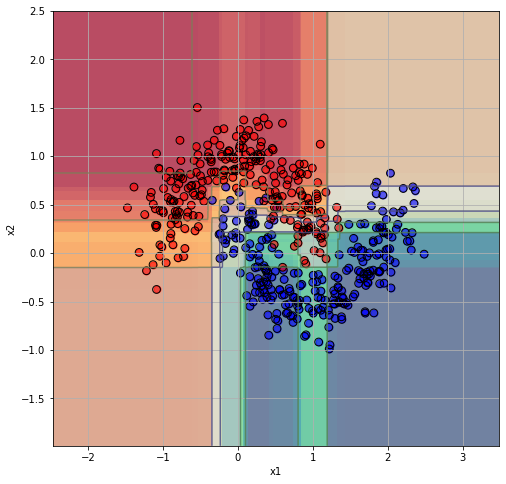

In [18]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(
    n_estimators=10, 
    min_samples_leaf=20, 
    random_state=42)

rf_clf.fit(X, y)

predicted = rf_clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1].reshape(xx.shape)

make_plot(X, y, predicted)

## 2.3.3 Gradient Boosting

Бустинг представляет собой жадный алгоритм построения композиции алгоритмов. Основная идея заключается в том, чтобы, имея множество относительно слабых алгоритмов обучения, построить их хорошую линейную комбинацию. Он похож на бэггинг тем, что базовый алгоритм обучения фиксирован. Отличие состоит в том, что обучение базовых алгоритмов для композиции происходит итеративно, и каждый следующий алгоритм стремится компенсировать недостатки композиции всех предыдущих алгоритмов.

На примере бустинга стало ясно, что хорошим качеством могут обладать сколь угодно сложные композиции классификаторов, при условии, что они правильно настраиваются. Это развеяло существовавшие долгое время представления о том, что для повышения обобщающей способности необходимо ограничивать сложность алгоритмов. 

Впоследствии этот феномен бустинга получил теоретическое обоснование. Оказалось, что взвешенное голосование не увеличивает эффективную сложность алгоритма, а лишь сглаживает ответы базовых алгоритмов. Эффективность бустинга объясняется тем, что по мере добавления базовых алгоритмов увеличиваются отступы обучающих объектов. Причём бустинг продолжает раздвигать классы даже после достижения безошибочной классификации обучающей выборки.

Общая схема бустинга:
- Искомый ансамбль алгоритмов имеет вид $a(x) = \mbox{sign}(\sum_{t = 1}^T \alpha_t b_t(x))$, где $b_t$ - базовые алгоритмы.
- Ансамбль строится итеративно, оптимизируя на каждом шаге функционал $Q_t$, равный количеству ошибок текущей композиции на обучающей выборке.
- При добавлении слагаемого $\alpha_t b_t(x)$ в сумму, функционал $Q_t$ оптимизируется только по базовому алгоритму $b_t(x)$ и коэффициенту $\alpha_t$ при нём, все предыдущие слагаемые считаются фиксированными.
- Функционал $Q_t$ имеет вид суммы по объектам обучающей выборки пороговых функций вида $[y_i \sum_{j = 1}^t \alpha_j b_j(x_i) < 0]$, имеющих смысл "текущая композиция ошибается на объекте с номером $i$". Каждое такое слагаемое имеет вид "ступеньки" и является разрывной функцией. Для упрощения решения задачи оптимизации такая пороговая функция заменяется на непрерывно дифференцируемую оценку сверху. В итоге получается новый функционал $\hat{Q}_t \geqslant Q_t$, минимизация которого приводит к минимизации исходного функционала $Q_t$.

Используя различные аппроксимации для пороговой функции потерь $[z < 0]$, будем получать различные виды бустинга. Примеры:
- $e^{-z}$ - AdaBoost
- $\log_2(1 + e^{-z})$ - LogitBoost
- $(1 - z)^2$ - GentleBoost
- $e^{-cz(z+a)}$ - BrownBoost
- другие

Метод градиентного бустинга в некотором смысле является обобщением остальных методов бустинга, поскольку он позволяет оптимизировать произвольную дифференцируемую функцию потерь. Данный алгоритм похож на метод градиентного спуска, применяемый для решения задач оптимизации. Основная идея заключается в том, что каждый следующий добавляемый в композицию алгоритм настраивается на остатки предыдущих алгоритмов.

Пусть дана функция потерь дифференцируемая $\Large L(F(x), y)$. Сам алгоритм выглядит следующим образом:
- Инициализация композиции константным значением $\Large F_0(x) = \arg\min_{\alpha} \sum_{i=1}^n L(\alpha, y_i)$.
- Для всех $\Large t = 1, \dots, T$:
    * Вычислить остатки предыдущей композиции: $\Large r_{it} = -[\nabla_{F(x)} L(F(x_i), y_i)]_{F(x) = F_{t-1}(x)}, i = 1, \dots, n$.
    * Настроить базовый алгоритм $\Large b_t(x)$ на полученные остатки, т.е. обучить его по выборке $\Large \{(x_i, r_{it}), i = 1, \dots, n\}$.
    * Вычислить коэффициент $\alpha_t$ перед базовым алгоритмом $\Large b_t(x)$ как решение следующей одномерной задачи оптимизации:
    $\Large \alpha_t = \arg\min_\alpha \sum_{i=1}^n L(F_{t-1}(x_i) + \alpha b_t(x_i), y_i)$.
    * Добавить полученное слагаемое в композицию: $\Large F_t(x) = F_{t-1}(x) + \alpha_t b_t(x)$.
    
Одной из возможных модификаций данного алгоритма является стохастический градиентный бустинг (SGB), который заключается в том, чтобы вычислять суммы вида $\sum_{i=1}^n$ не по всей обучающей выборке, а только по некоторой её случайной подвыборке. Такой подход является одним из способов регуляризации данного алгоритма и позволяет улучшить качество композиции, сходимость алгоритма и время обучения. 

Другой способ регуляризации - это введение параметра $\gamma$, называемого темпом обучения. При добавлении нового слагаемого в композицию, будем добавлять его, умноженное на этот коэффициент. Как правило, чем меньше темп обучения, тем лучше качество итоговой композиции.

Для задач регресси обычно использую квадратичную функцию потерь $L(x, y) = (x - y)^2$ или модуль отклонения $L(x, y) = |x - y|$.
В задаче классификации используется логистическая функция потерь, которая позволяет возвращать вероятности принадлежности объектов к классам.

Одним из наиболее популярных семейств базовых алгоритмов являются решающие деревья. Именно такой вариант градиентного бустинга <a href="http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html">реализован</a> в sklearn.

<ipython-input-2-1d6dfb51e877>:13: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, predicted, cmap='Spectral')


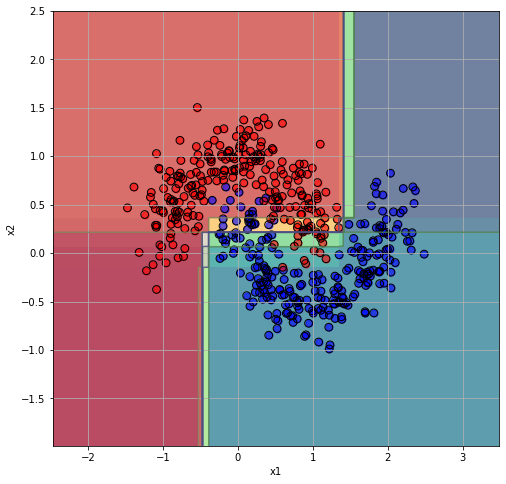

In [19]:
from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(
    max_depth=2,
    n_estimators=10,
    learning_rate=0.1,
    random_state=42)

gbrt.fit(X, y)

predicted = gbrt.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

make_plot(X, y, predicted)